In [1]:
using Pkg
Pkg.activate(".")

#pkg"add StatsBase"
#pkg"add https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl"

using JLD2, CSV, DataFrames
import PyPlot as plt
using PyCall
using Statistics#, StatsPlots
using LaTeXStrings

rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 9 #9 #18


  Activating project at `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/SI_inference`


UndefVarError: UndefVarError: `matplotlib` not defined

In [2]:
# Function to calculate standard error of the mean
sem(x) = std(x) / sqrt(length(x))

# Function to calculate the standard error the median
semedian(x) = sem(x) * 1.2533

include("optim_pars.jl");

# Proximity

In [20]:
save_vec = JLD2.load_object("optim_pars_rand_geom.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/rnd_geom.csv", DataFrame)
select!(df, Not([:EPI]))
df[!, :SCDC_new] = aucs
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/rnd_geom.csv", df)

"data/plot_data/rnd_geom.csv"

# Watts-Strogatz

In [22]:
save_vec = JLD2.load_object("optim_pars_watts_strogatz.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
a = aucs[findall(x->x==minimum(aucs),aucs)[1]]
filter!(x->x!=a, aucs)
auc_median = median(aucs)
auc_err = semedian(aucs)
df = CSV.read("data/old_data/WS.csv", DataFrame)
select!(df, Not([:EPI]))
df[!, :SCDC_new] = aucs
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/WS.csv", df)

"data/plot_data/WS.csv"

# OpenABM

In [30]:
save_vec = JLD2.load_object("optim_pars_openABM.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/openABM.csv", DataFrame)
select!(df, Not([:EPI]))
df[!, :SCDC_new] = aucs
rename!(df, :MF_d15 => :MF)
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/openABM.csv", df)

"data/plot_data/openABM.csv"

# Covasim

In [24]:
save_vec = JLD2.load_object("optim_pars_covasim.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/covasim.csv", DataFrame)
select!(df, Not([:EPI, :MF]))
df[!, :SCDC_new] = aucs
rename!(df, :MF_d15 => :MF)
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/covasim.csv", df)

"data/plot_data/covasim.csv"

# Plot random graphs

Proximity random graphs
SMF: 0.8020425900962959 ± 0.007577670306129443
BP: 0.9456152584613635 ± 0.003644439982458618
SCDCt: 0.9361769777178632 ± 0.0046658492532561085
SCDCe: 0.9338054662230658 ± 0.003909138631294046


OpenABM contact network
SMF: 0.6839970916043222 ± 0.0026446342322927617
BP: 0.7492304270425126 ± 0.0034722104255103165
SCDCt: 0.7490829297001395 ± 0.003568366288593721
SCDCe: 0.7420816094964523 ± 0.003572007948613897


Watts-Strogats random graphs
SMF: 0.6456158264568821 ± 0.006225172418917031
BP: 0.7989741859137217 ± 0.0068485962921422975
SCDCt: 0.8000110319476766 ± 0.007319202822352979
SCDCe: 0.8040196984205785 ± 0.006459586573516673


Covasim contact network
SMF: 0.5915569925277634 ± 0.0023397590595883146
BP: 0.668311285522543 ± 0.003107867690705715
SCDCt: 0.668035562180005 ± 0.0031267022310317387
SCDCe: 0.6530061161221258 ± 0.0034322528489331497




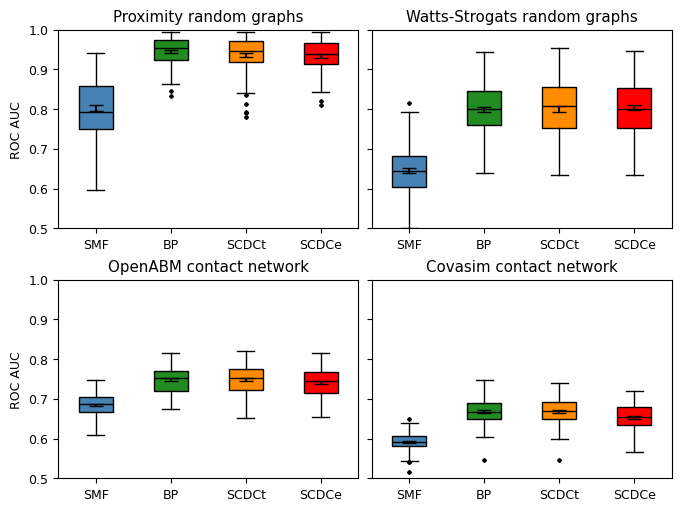

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(6.7, 5), layout="constrained") #(15,5) (6.7, 3)

labels = ["SMF", "BP", "SCDCt", "SCDCe"]
colors = ["steelblue", "forestgreen", "darkorange", "red"]

medianprops = Dict("color"=>"black")
flierprops = Dict("marker"=>"D", "markerfacecolor"=>"black", "markersize"=>2)

titles = ["Proximity random graphs", "OpenABM contact network", "Watts-Strogats random graphs", "Covasim contact network"]
for (i, graph) in enumerate(["rnd_geom", "openABM", "WS", "covasim"])
    df = CSV.read("data/plot_data/$(graph).csv", DataFrame)
    bplot = axs[i].boxplot(Matrix(df), labels=labels, patch_artist=true, medianprops=medianprops, flierprops=flierprops)
    axs[i].set_title(titles[i])
    axs[i].set_ylim((0.5,1.0))
    
    for (ip, patch) in enumerate(bplot["boxes"])
        patch.set_facecolor(colors[ip])
    end
    println(titles[i])
    for im in 1:4
        auc_m = mean(df[!,im])
        auc_err = sem(df[!, im])
        println(labels[im]*": $(auc_m) ± $(auc_err)")
        
        # Add error bar to the median value
        axs[i].errorbar(im, auc_m, yerr=auc_err, fmt="o", color="black", capsize=5, markersize=0)
    end
    println("\n")
end

axs[3].set_yticklabels([])
axs[4].set_yticklabels([])
axs[1].set_ylabel("ROC AUC")
axs[2].set_ylabel("ROC AUC")

plt.display(fig)
fig.savefig("comparison_randomgraphs.pdf")

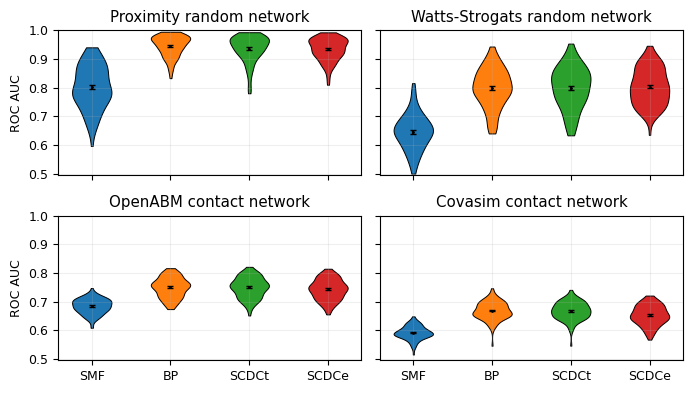

Proximity random network
SMF: 0.8020425900962959 ± 0.007577670306129443
BP: 0.9456152584613635 ± 0.003644439982458618
SCDCt: 0.9361769777178632 ± 0.0046658492532561085
SCDCe: 0.9338054662230658 ± 0.003909138631294046


OpenABM contact network
SMF: 0.6839970916043222 ± 0.0026446342322927617
BP: 0.7492304270425126 ± 0.0034722104255103165
SCDCt: 0.7490829297001395 ± 0.003568366288593721
SCDCe: 0.7420816094964523 ± 0.003572007948613897


Watts-Strogats random network
SMF: 0.6456158264568821 ± 0.006225172418917031
BP: 0.7989741859137217 ± 0.0068485962921422975
SCDCt: 0.8000110319476766 ± 0.007319202822352979
SCDCe: 0.8040196984205785 ± 0.006459586573516673


Covasim contact network
SMF: 0.5915569925277634 ± 0.0023397590595883146
BP: 0.668311285522543 ± 0.003107867690705715
SCDCt: 0.668035562180005 ± 0.0031267022310317387
SCDCe: 0.6530061161221258 ± 0.0034322528489331497




In [15]:
fig, axs = plt.subplots(2, 2, figsize=(7,4), tight_layout=true, sharey=true, sharex=true) #(15,5) (6.7, 3)

labels = ["SMF", "BP", "SCDCt", "SCDCe"]
colors = ["C0", "C1", "C2", "C3"]

titles = ["Proximity random network", "OpenABM contact network", "Watts-Strogats random network", "Covasim contact network"]
for (i, graph) in enumerate(["rnd_geom", "openABM", "WS", "covasim"])
    df = CSV.read("data/plot_data/$(graph).csv", DataFrame)
    
    vplot = axs[i].violinplot(Matrix(df), showmeans=false, showextrema=false, showmedians=false)
    axs[i].set_title(titles[i])
    axs[i].set_ylim((0.495,1.0))
    axs[i].set_xticks(1:4, labels=labels)
    axs[i].grid(alpha=.2)
    #axs[i].yaxis.grid(true)

    for (ip, patch) in enumerate(vplot["bodies"])
        patch.set_facecolor(colors[ip])
        patch.set_alpha(1.0)
        patch.set_edgecolor("black")
        patch.set_linewidth(.7)
    end

    println(titles[i])
    for im in 1:4
        #auc_m = median(df[!,im])
        #auc_err = semedian(df[!, im])
        auc_m = mean(df[!,im])
        auc_err = sem(df[!, im])
        println(labels[im]*": $(auc_m) ± $(auc_err)")
        
        # Add error bar to the median value
        axs[i].errorbar(im, auc_m, yerr=auc_err, fmt="o", color="black", capsize=2, markersize=1)
    end
    println("\n")
end

axs[1].set_yticks(0.5:0.1:1.0)
axs[2].set_yticks(0.5:0.1:1.0)
axs[1].set_ylabel("ROC AUC")
axs[2].set_ylabel("ROC AUC")

plt.display(fig)
fig.savefig("comparison_randomgraphs.pdf", format="pdf", bbox_inches="tight")

# Office12

In [34]:
save_vec = JLD2.load_object("optim_pars_office12.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/work_12.csv", DataFrame)
select!(df, Not([:EPI]))
df[!, :SCDC_new] = aucs
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/work_12.csv", df)

"data/plot_data/work_12.csv"

# Office24

In [35]:
save_vec = JLD2.load_object("optim_pars_office24.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/work_24.csv", DataFrame)
select!(df, Not([:EPI]))
df[!, :SCDC_new] = aucs
rename!(df, :MF_t6_d20 => :MF)
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/work_24.csv", df)

"data/plot_data/work_24.csv"

# School18

In [36]:
save_vec = JLD2.load_object("optim_pars_school18.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/thiers_18.csv", DataFrame)
select!(df, Not([:EPI, :sib]))
df[!, :SCDC_new] = aucs
rename!(df, :MF_tau3_d10 => :MF, :EPI_corr => :EPI_med, :sib_mean => :sib)
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/thiers_18.csv", df)

"data/plot_data/thiers_18.csv"

# School36

In [37]:
save_vec = JLD2.load_object("optim_pars_school36.jld2")
aucs = [save_struct.AUC for save_struct in save_vec]
df = CSV.read("data/old_data/thiers_36.csv", DataFrame)
select!(df, Not([:EPI, :sib]))
df[!, :SCDC_new] = aucs
rename!(df, :MF_tau6_d20 => :MF, :EPI_corr => :EPI_med, :sib_mean => :sib)
select!(df, [:MF, :sib, :EPI_med, :SCDC_new])
CSV.write("data/plot_data/thiers_36.csv", df)

"data/plot_data/thiers_36.csv"

# Plot real graphs

Office network, $T = 12, \, \tau_w = 24 h$
SMF: 0.7355350079180849 ± 0.006303248837358309
BP: 0.8204800470722431 ± 0.00672915631556611
SCDCt: 0.8187732524415199 ± 0.006704528452087394
SCDCe: 0.814034681573695 ± 0.007007266440711198


School network, $T = 18, \, \tau_w = 6 h$
SMF: 0.8279202951212076 ± 0.010763797184021285
BP: 0.901711341598755 ± 0.006980081497587322
SCDCt: 0.8964990335997961 ± 0.007756447125526761
SCDCe: 0.8863399060518038 ± 0.0065847464279373295


Office network, $T = 24,\, \tau_w = 12 h$
SMF: 0.7277035481801719 ± 0.006035359381868324
BP: 0.8116022747186223 ± 0.006339959649435916
SCDCt: 0.8093147169036496 ± 0.006399023086130082
SCDCe: 0.7949812205131355 ± 0.00646296574564875


School network, $T = 36,\, \tau_w = 3 h$
SMF: 0.8062410884807909 ± 0.009596809952361975
BP: 0.8939305608433419 ± 0.007836304114503744
SCDCt: 0.8836510698789986 ± 0.007947290427321091
SCDCe: 0.8965046380536474 ± 0.006644332482701088




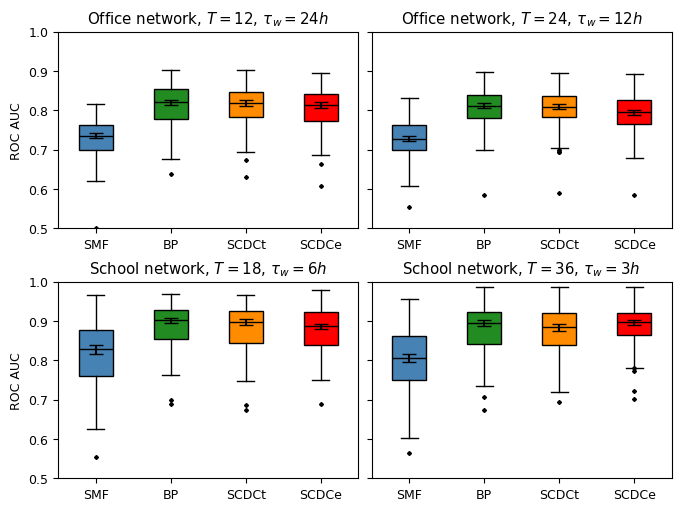

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(6.7, 5), layout="constrained") #(15,5) (6.7, 3)

labels = ["SMF", "BP", "SCDCt", "SCDCe"]
colors = ["steelblue", "forestgreen", "darkorange", "red"]

medianprops = Dict("color"=>"black")
flierprops = Dict("marker"=>"D", "markerfacecolor"=>"black", "markersize"=>2)

titles = ["Office network, " * L"$T = 12, \, \tau_w = 24 h$", "School network, "* L"$T = 18, \, \tau_w = 6 h$", "Office network, "*L"$T = 24,\, \tau_w = 12 h$", "School network, "*L"$T = 36,\, \tau_w = 3 h$"]
for (i, graph) in enumerate(["work_12", "thiers_18", "work_24", "thiers_36"])
    df = CSV.read("data/plot_data/$(graph).csv", DataFrame)
    bplot = axs[i].boxplot(Matrix(df), labels=labels, patch_artist=true, medianprops=medianprops, flierprops=flierprops)
    axs[i].set_title(titles[i])
    axs[i].set_ylim((0.5,1.0))
    
    for (ip, patch) in enumerate(bplot["boxes"])
        patch.set_facecolor(colors[ip])
    end
    println(titles[i])
    for imedian in 1:4
        auc_median = median(df[!,imedian])
        auc_err = semedian(df[!, imedian])
        println(labels[imedian]*": $(auc_median) ± $(auc_err)")
        
        # Add error bar to the median value
        axs[i].errorbar(imedian, auc_median, yerr=auc_err, fmt="o", color="black", capsize=5, markersize=0)
    end
    println("\n")
end

axs[3].set_yticklabels([])
axs[4].set_yticklabels([])
axs[1].set_ylabel("ROC AUC")
axs[2].set_ylabel("ROC AUC")

plt.display(fig)
fig.savefig("comparison_realgraphs_boxplot.pdf")

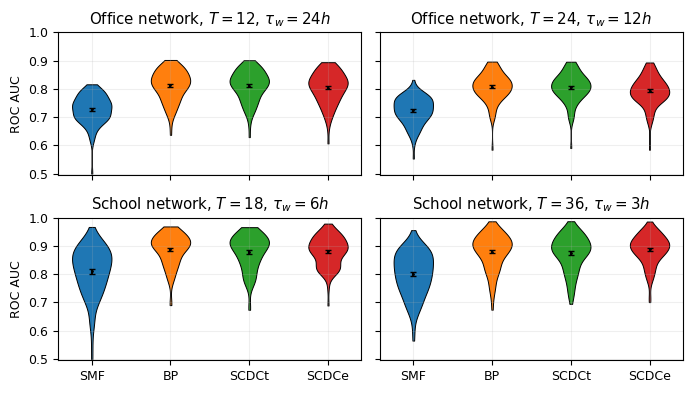

Office network, $T = 12, \, \tau_w = 24 h$
SMF: 0.7282098987383446 ± 0.005029321660702392
BP: 0.8128381194572255 ± 0.005369150495145703
SCDCt: 0.8116008988552204 ± 0.005349500081454874
SCDCe: 0.8042447676687421 ± 0.005591052773247585


School network, $T = 18, \, \tau_w = 6 h$
SMF: 0.8102923120836213 ± 0.00858836446502935
BP: 0.8876160881468843 ± 0.005569362082172921
SCDCt: 0.8782275931319019 ± 0.006188819217686716
SCDCe: 0.8806784654887043 ± 0.005253926775662115


Office network, $T = 24,\, \tau_w = 12 h$
SMF: 0.7238857203643869 ± 0.004815574389107415
BP: 0.8073477190237084 ± 0.005058612981278158
SCDCt: 0.8060171870310912 ± 0.005105739317106903
SCDCe: 0.793210481602012 ± 0.005156758753409998


School network, $T = 36,\, \tau_w = 3 h$
SMF: 0.8001331484401614 ± 0.007657232867120382
BP: 0.8795891065525672 ± 0.006252536594992216
SCDCt: 0.8742430042656479 ± 0.0063410918593481925
SCDCe: 0.8874791099526996 ± 0.00530147010508345




In [9]:
fig, axs = plt.subplots(2, 2, figsize=(7,4), tight_layout=true, sharey=true, sharex=true)#(15,5) (6.7, 3)

labels = ["SMF", "BP", "SCDCt", "SCDCe"]
colors = ["C0", "C1", "C2", "C3"]

medianprops = Dict("color"=>"black")
flierprops = Dict("marker"=>"D", "markerfacecolor"=>"black", "markersize"=>2)

titles = ["Office network, " * L"$T = 12, \, \tau_w = 24 h$", "School network, "* L"$T = 18, \, \tau_w = 6 h$", "Office network, "*L"$T = 24,\, \tau_w = 12 h$", "School network, "*L"$T = 36,\, \tau_w = 3 h$"]
for (i, graph) in enumerate(["work_12", "thiers_18", "work_24", "thiers_36"])
    df = CSV.read("data/plot_data/$(graph).csv", DataFrame)
    
    vplot = axs[i].violinplot(Matrix(df), showmeans=false, showextrema=false, showmedians=false)
    axs[i].set_title(titles[i])
    axs[i].set_ylim((0.495,1.0))
    axs[i].set_xticks(1:4, labels=labels)
    axs[i].grid(alpha=.2)
    #axs[i].yaxis.grid(true)

    for (ip, patch) in enumerate(vplot["bodies"])
        patch.set_facecolor(colors[ip])
        patch.set_alpha(1.0)
        patch.set_edgecolor("black")
        patch.set_linewidth(.7)
    end

    println(titles[i])
    for im in 1:4
        #auc_m = median(df[!,im])
        #auc_err = semedian(df[!, im])
        auc_m = mean(df[!,im])
        auc_err = sem(df[!, im])
        println(labels[im]*": $(auc_m) ± $(auc_err)")
        
        # Add error bar to the median value
        axs[i].errorbar(im, auc_m, yerr=auc_err, fmt="o", color="black", capsize=2, markersize=1)
    end
    println("\n")
end


axs[1].set_yticks(0.5:0.1:1.0)
axs[2].set_yticks(0.5:0.1:1.0)
axs[1].set_ylabel("ROC AUC")
axs[2].set_ylabel("ROC AUC")

plt.display(fig)
fig.savefig("comparison_realgraphs.pdf", format="pdf", bbox_inches="tight")

# Plot paper

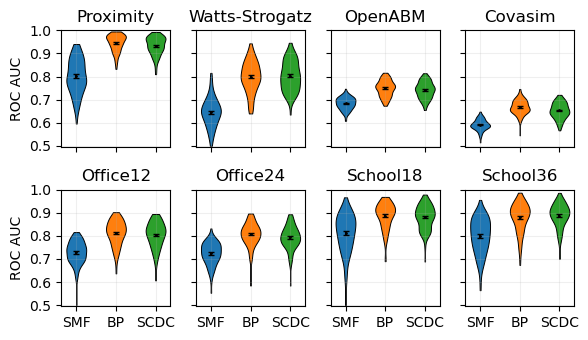

Proximity
SMF: 0.8020425900962959 ± 0.007577670306129443
BP: 0.9456152584613635 ± 0.003644439982458618
SCDC: 0.9338054662230658 ± 0.003909138631294046


Office12
SMF: 0.7282098987383446 ± 0.005029321660702392
BP: 0.8128381194572255 ± 0.005369150495145703
SCDC: 0.8042447676687421 ± 0.005591052773247585


Watts-Strogatz
SMF: 0.6456158264568821 ± 0.006225172418917031
BP: 0.7989741859137217 ± 0.0068485962921422975
SCDC: 0.8040196984205785 ± 0.006459586573516673


Office24
SMF: 0.7238857203643869 ± 0.004815574389107415
BP: 0.8073477190237084 ± 0.005058612981278158
SCDC: 0.793210481602012 ± 0.005156758753409998


OpenABM
SMF: 0.6839970916043222 ± 0.0026446342322927617
BP: 0.7492304270425126 ± 0.0034722104255103165
SCDC: 0.7420816094964523 ± 0.003572007948613897


School18
SMF: 0.8102923120836213 ± 0.00858836446502935
BP: 0.8876160881468843 ± 0.005569362082172921
SCDC: 0.8806784654887043 ± 0.005253926775662115


Covasim
SMF: 0.5915569925277634 ± 0.0023397590595883146
BP: 0.668311285522543 ± 0

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(6,3.5), tight_layout=true, sharey=true, sharex=true) #(15,5) (6.7, 3)

labels = ["SMF", "BP", "SCDC"]
colors = ["C0", "C1", "C2"]

titles = ["Proximity", "Office12", "Watts-Strogatz", "Office24", "OpenABM", "School18", "Covasim", "School36"]
for (i, graph) in enumerate(["rnd_geom", "work_12", "WS", "work_24", "openABM", "thiers_18", "covasim", "thiers_36"])
    df = CSV.read("data/plot_data/$(graph).csv", DataFrame)
    select!(df, [:MF, :sib, :SCDC_new])
    
    vplot = axs[i].violinplot(Matrix(df), showmeans=false, showextrema=false, showmedians=false)
    axs[i].set_title(titles[i])
    axs[i].set_ylim((0.495,1.0))
    axs[i].set_xticks(1:length(labels), labels=labels)
    axs[i].grid(alpha=.2)
    #axs[i].yaxis.grid(true)

    for (ip, patch) in enumerate(vplot["bodies"])
        patch.set_facecolor(colors[ip])
        patch.set_alpha(1.0)
        patch.set_edgecolor("black")
        patch.set_linewidth(.7)
    end

    println(titles[i])
    for im in 1:length(labels)
        #auc_m = median(df[!,im])
        #auc_err = semedian(df[!, im])
        auc_m = mean(df[!,im])
        auc_err = sem(df[!, im])
        println(labels[im]*": $(auc_m) ± $(auc_err)")
        
        # Add error bar to the median value
        axs[i].errorbar(im, auc_m, yerr=auc_err, fmt="o", color="black", capsize=2, markersize=1)
    end
    println("\n")
end

axs[1].set_yticks(0.5:0.1:1.0)
axs[2].set_yticks(0.5:0.1:1.0)
axs[1].set_ylabel("ROC AUC")
axs[2].set_ylabel("ROC AUC")

plt.display(fig)
fig.savefig("comparison.pdf", format="pdf", bbox_inches="tight")